In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from pareto_sampler import pareto
from inelasticity_sampler import inelasticity_sampler
from effective_area import get_effective_area_interpolator
from direction_sampler import uniform_from_sphere
from hadronic_factor import sample_hadronic_reduction_factor

plt.style.use('ggplot')

In [24]:
# Generation parameters
lEmin = 3.0
lEmax = 7.0
gamma = 1.1

interaction = 'nu_NC' # nu_NC, nubar_NC

nsamples = int(1e6)

In [25]:
# Sample primary information
# pareto = pareto_sampler(Emin=10**lEmin, Emax=10**lEmax)
# neutrino_energies = pareto.sample_pareto(gamma=gamma, size=nsamples)
p_sampler = pareto(gamma=gamma, lower=10**lEmin, upper=10**lEmax)

# neutrino_energies = pareto.sample_pareto(gamma=gamma, size=nsamples)
neutrino_energies = p_sampler.sample_pareto(size=nsamples)
neutrino_energies_log = np.log10(neutrino_energies)

neutrino_directions = uniform_from_sphere(nsamples)
neutrino_cos_thetas = np.asarray(neutrino_directions[:,0])

In [26]:
# Calculate weights
aeff_interpolator = get_effective_area_interpolator()
effective_areas = np.asarray([aeff_interpolator(lE, ct) 
                                      for lE, ct in zip(neutrino_energies_log, neutrino_cos_thetas)])

energy_probabilities = p_sampler.pdf(neutrino_energies)
# energy_probabilities = np.asarray([pareto.pareto_pdf(E, gamma=gamma) 
#                                  for E in neutrino_energies])
# energy_probabilities = np.asarray([pareto.pareto_pdf(E, gamma=gamma) 
#                                  for E in neutrino_energies])
weights = 1./nsamples * effective_areas / energy_probabilities * 4. * np.pi * 10.**4

In [27]:
# Calculate bjorken y for inelasticties
inel = inelasticity_sampler()
bjorken_y = np.asarray([inel.draw_inelasticity(energy=E, interaction=interaction)
                        for E in neutrino_energies])

In [28]:
# NC only
e_had = bjorken_y * neutrino_energies
hadr_factor = np.vectorize(sample_hadronic_reduction_factor)(e_had)
e_dep = hadr_factor * e_had 

Expected number of events: 221.501340199


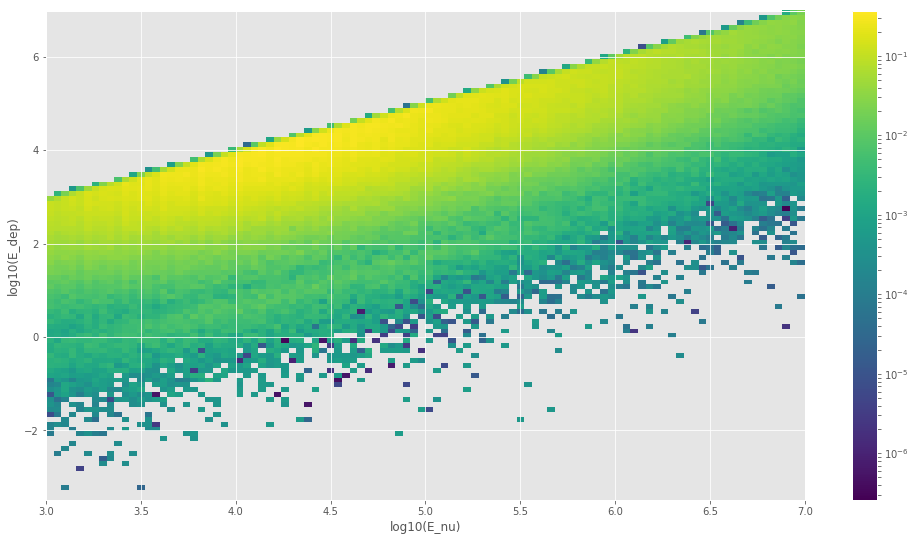

In [29]:
# Flux model for weighting
gamma = 2.0
norm = 1.*10**(-18)
ltime = 365. * 24. * 3600. * 2. # assume 2 years of livetime for rate

weights_plot=weights*np.power(neutrino_energies/1.e5,-gamma)* norm * ltime
rate = np.sum(weights_plot)
print 'Expected number of events:', rate
plt.figure(figsize=(17,9))
plt.hist2d(neutrino_energies_log, np.log10(e_dep), weights=weights_plot, norm=LogNorm(), bins=100)
plt.xlabel('log10(E_nu)')
plt.ylabel('log10(E_dep)')
plt.colorbar()
plt.show()